In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Measuring the "time of arrival" of a pulsar
## Crab Pulsar Experiment Part 3.2

This notebook can be used for the first part of the crab timing part of the experiment. Here you will find code that reads your data files (pulsar archives) and matches the observed pulse against a _standard template_ of the crab pulsar. This standard template is a noise-free model of the shape of the pulse and we can measure the time that the pulse arrived to very high precision by correlating the known shape of the pulse (the template) with the noisy data.

The code is in four main parts:
 1. Specifying the data location
 2. Dedispersion of the data ( **insert your code from Part 1 here** )
 3. Measuring the time of arrival (ToA)
 4. Visualising the result
 
_You will need to run all three parts in sequence to get the right results._ Visualising the output is important to be sure you have got sensible results.



# Load Data

In [2]:
filename="example_data/20220524_170331_B0531+21.npz"
obsdata = np.load(filename)
print(obsdata['header'])
data=obsdata['data']

Filename                      : 20220524_170331_B0531+21.cln
Source Name                   : B0531+21
Number of channels            : 40
Number of phase bins          : 1024
Number of sub-integrations    : 43
Centre Freq (MHz)             : 611.0
Bandwidth (MHz)               : 10.0
Integration Time (s)          : 8460.0
Telescope                     : Jodrell


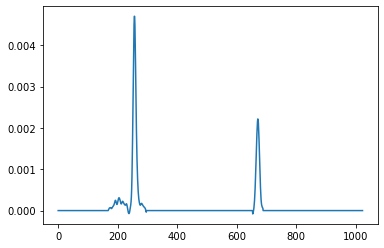

In [3]:
template=np.loadtxt("template.txt")
plt.plot(template)
plt.show()

# Dedispersing and averaging in Frequency

In [4]:
##
#  This function will shift each row of a 2-d (3-d) array by the the number of columns specified in the "shifts" array.
#  data_in - the 2-d (3-d) array to work on
#  shifts - the shifts to apply
#  Returns: The shifted array
##
def shift_rows(data_in, shifts):
    shifted = np.zeros_like(data_in)
    if data_in.ndim == 3:
        for i in range(data_in.shape[0]):
            shifted[i] = shift_rows(data_in[i],shifts)
    else:
        for i in range(data_in.shape[0]):
            shifted[i] = np.roll(data_in[i],int(shifts[i]))
    return shifted


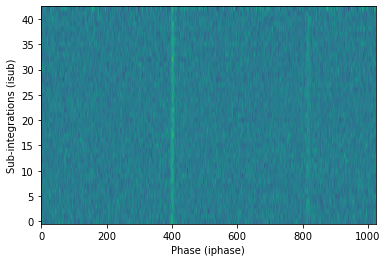

In [5]:
## Insert your de-dispersion code here
# ... 
# Create a de-dispersed frequency-averaged data called ddfreq_averaged
# ddfreq_averaged = 
#

nsub, nchan,nphase = data.shape
ichan=np.arange(nchan)
dm=59
freq = ((ichan /nchan)+0.5)*10 + 611
timedelay=-dm/(2.42e-4*freq**2)
bindelay = timedelay * (nphase/obsdata['approx_period'])
dd_data = shift_rows(data,bindelay)

# We can integrate over all frequency channels by using the `sum` routine from numpy...
ddfreq_averaged = np.mean(dd_data,axis=1)
plt.imshow(ddfreq_averaged,aspect='auto',origin='lower')
plt.xlabel("Phase (iphase)")
plt.ylabel("Sub-integrations (isub)")
plt.show()



## Computing the time of arrivals
**Please don't worry too much about how this code works.** This is based on research software used for experiments ranging searching for planets around pulsars to measuring gravitational waves passing over the earth. It has been annotated with a few comments for the curious, but you can mostly just treat this as a black box you can use to get time of arrival measurements for your pulsar data.
If you are desparate to dig into the details, this code is based on the ToA estimation procedure described in Appendix A of Taylor et al. 1992. (https://www.jstor.org/stable/53915)

In [6]:
# Equation A7 in Taylor 1992
def get_dchi(tau,N,nbin):
    dphi = np.angle(xspec)[1:N]
    
    k=np.arange(1,N)

    dchi = np.sum(k*np.abs(f_prof[1:N])*np.abs(f_template[1:N]) * np.sin(dphi + 2*np.pi*k*tau/nbin))
    return dchi


# Equation A9 in Taylor 1992
def get_b(tau,N,nbin):
    dphi = np.angle(xspec)[1:N]
    k=np.arange(1,N)
    scale = np.sum(np.abs(f_prof[1:N])*np.abs(f_template[1:N]) * np.cos(dphi + 2*np.pi*k*tau/nbin))
    scale /= np.sum(np.abs(f_template[1:N])**2)
    return scale
    
    
# Equation A10 in Taylor 1992
def get_sigma_tau(tau,N,nbin,b):
    dphi = np.angle(xspec)[1:N]
    k=np.arange(1,N)
    chi2=np.sum(np.abs(f_prof[1:N])**2 + b**2*np.abs(f_template[1:N]) )-2*b*np.sum(np.abs(f_prof[1:N])*np.abs(f_template[1:N]) * np.cos(dphi + 2*np.pi*k*tau/nbin))
    sigma2 = chi2/(N-1)
    de = np.sum((k**2) * np.abs(f_prof[1:N])*np.abs(f_template[1:N]) * np.cos(dphi + 2*np.pi*k*tau/nbin))
    fac=nbin/(2*np.pi)
    return np.sqrt(sigma2/(2*b*de))*fac

# Just for plotting, rotates an array by a fractional phase shift using Fourier transform
def rotate_phs(ff,phase_shift):
    fr = ff*np.exp(1.0j*2*np.pi*np.arange(len(ff))*phase_shift)
    return np.fft.irfft(fr)



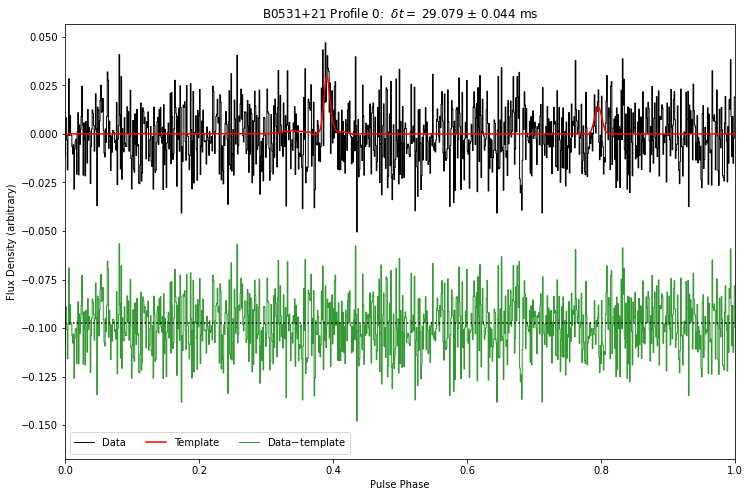

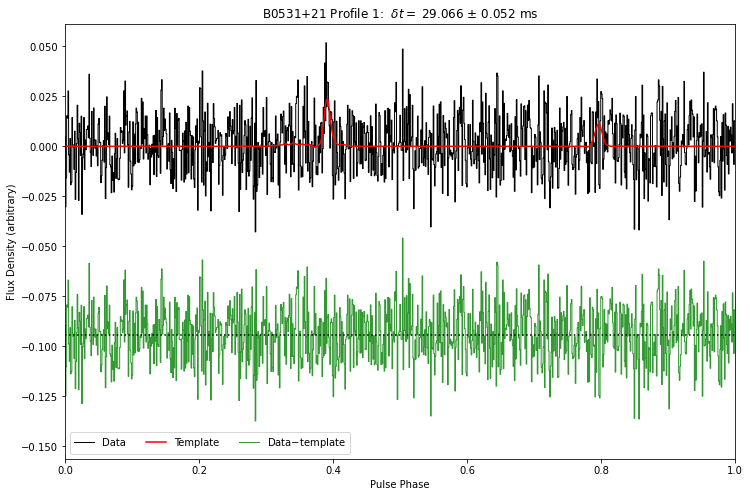

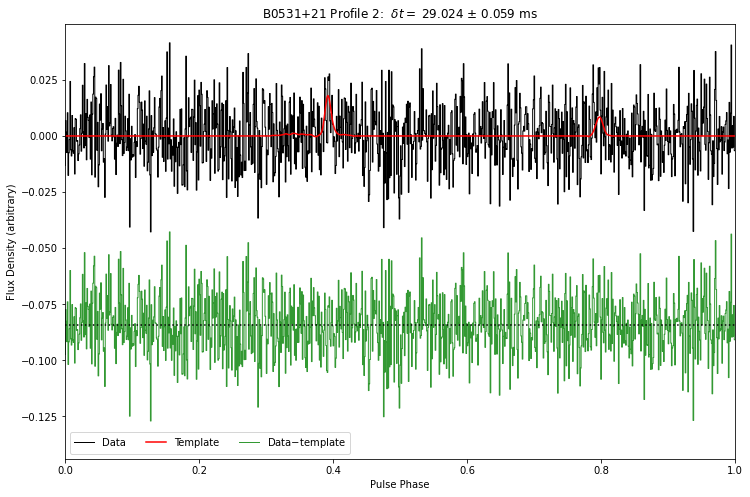

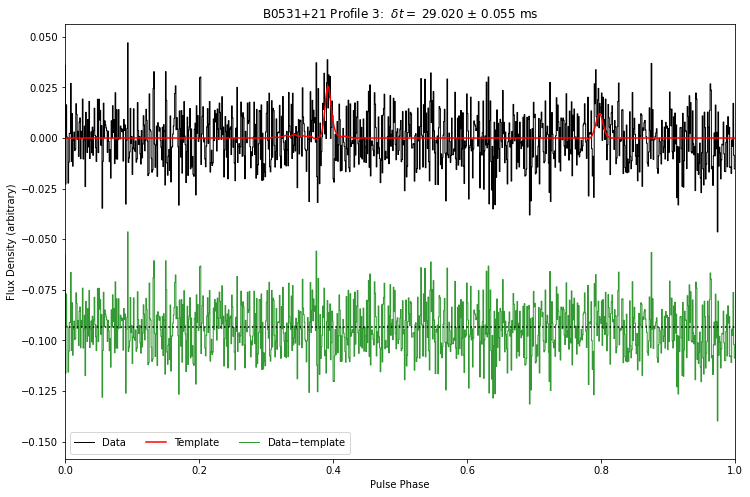

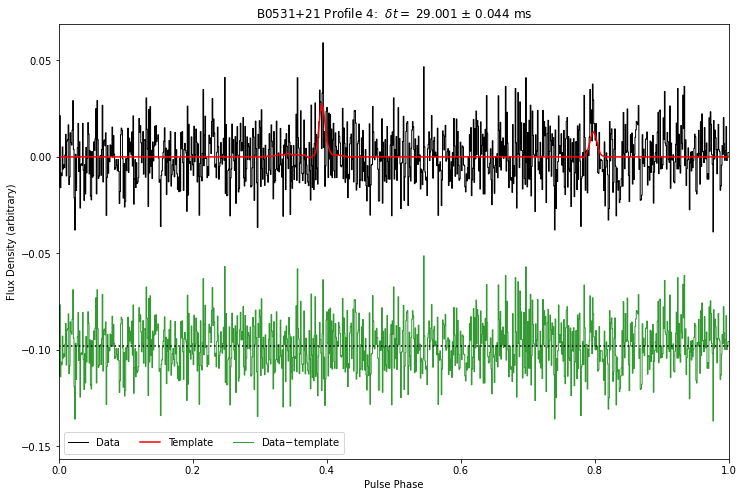

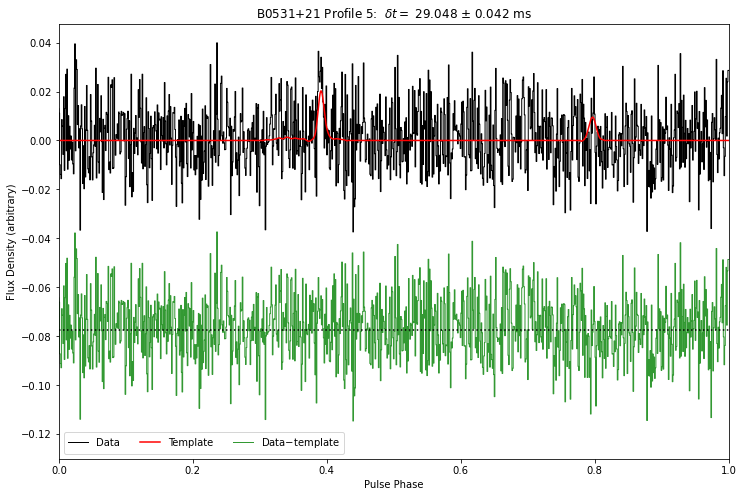

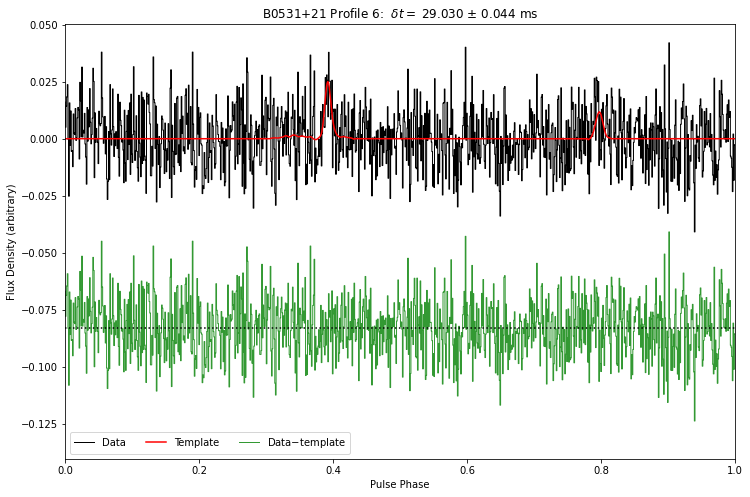

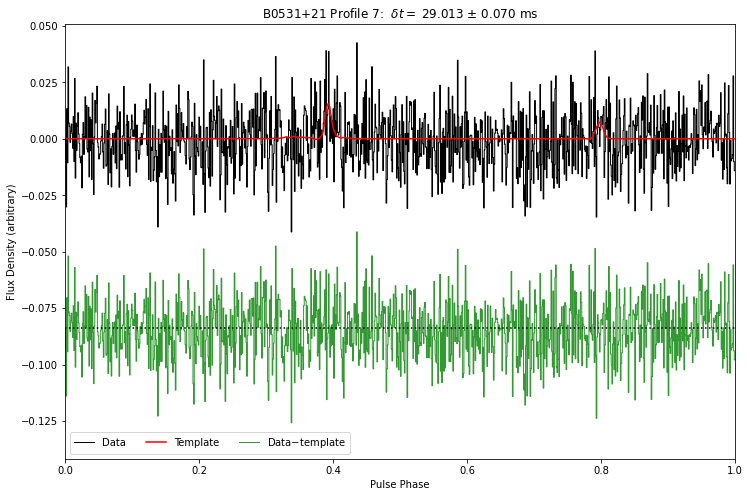

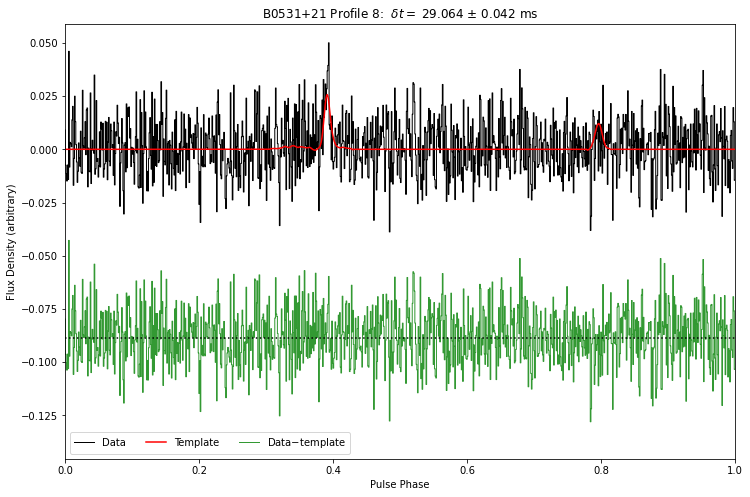

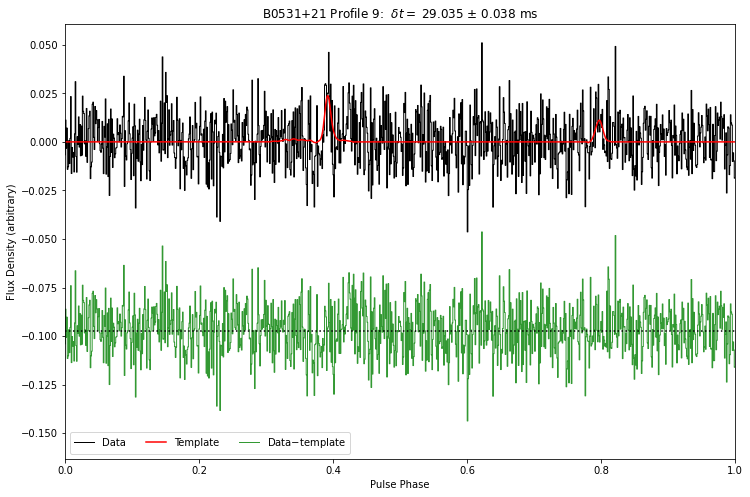

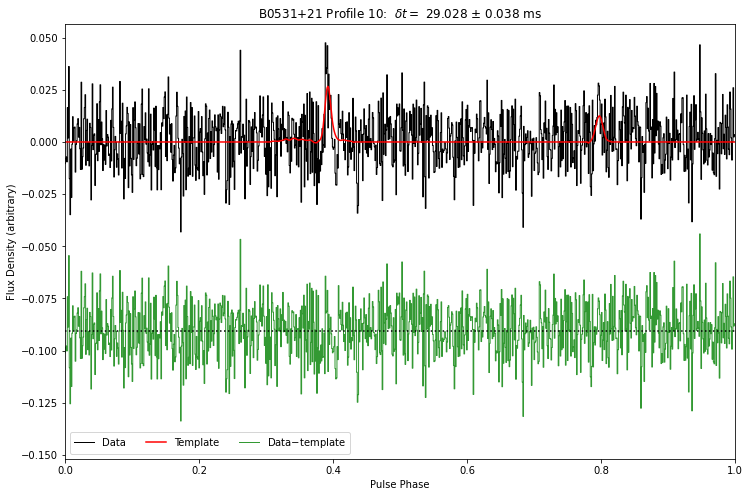

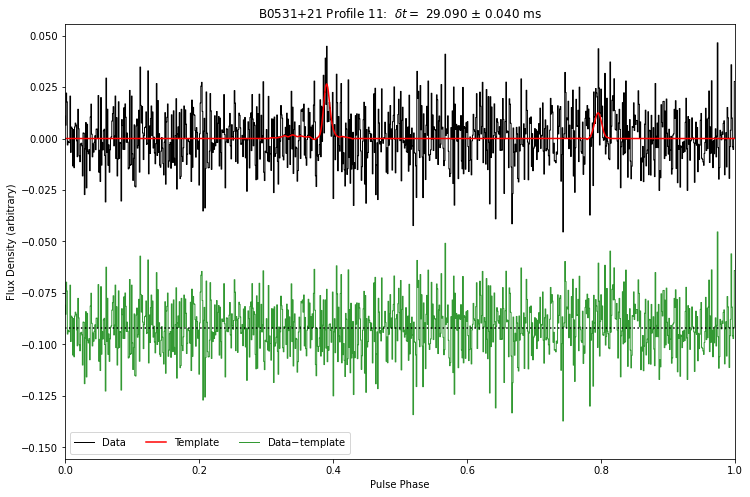

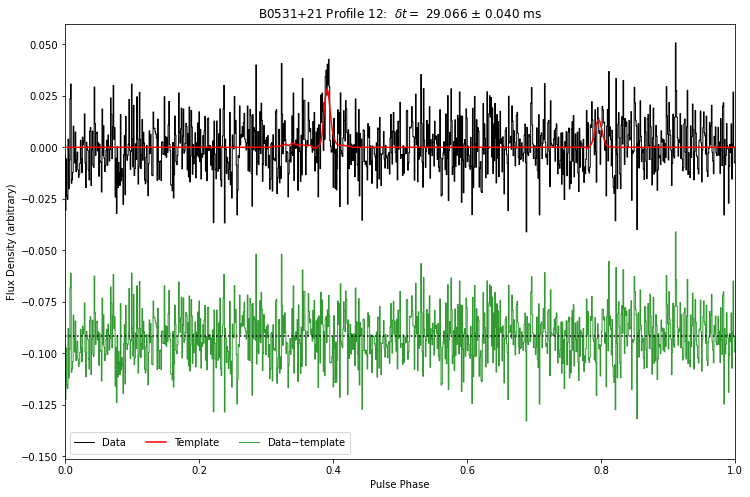

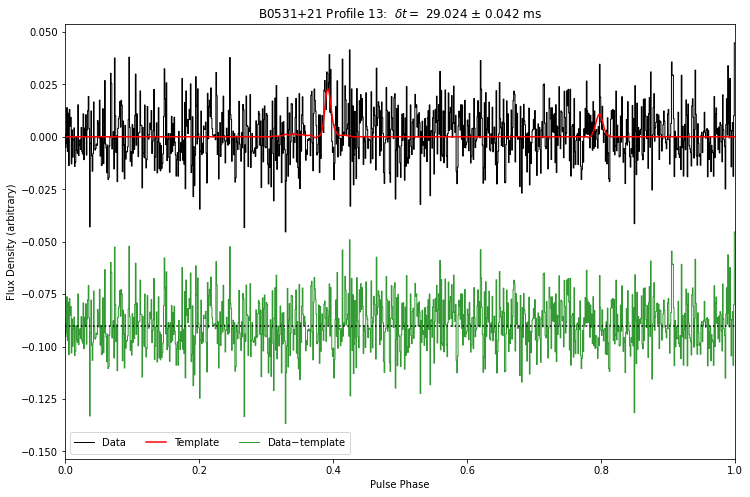

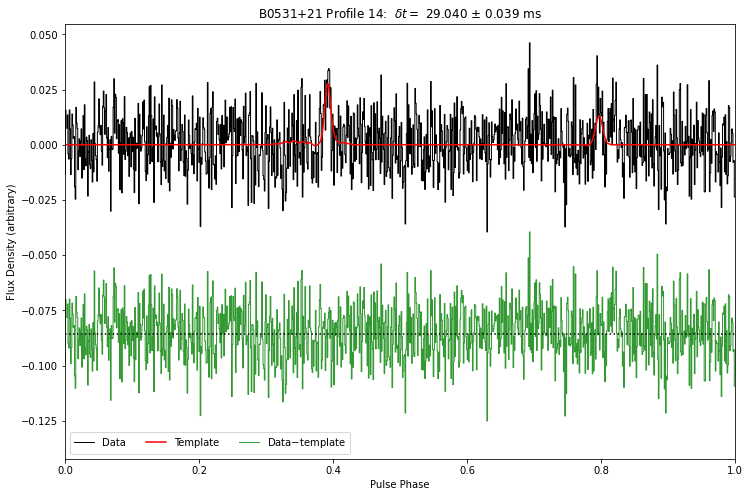

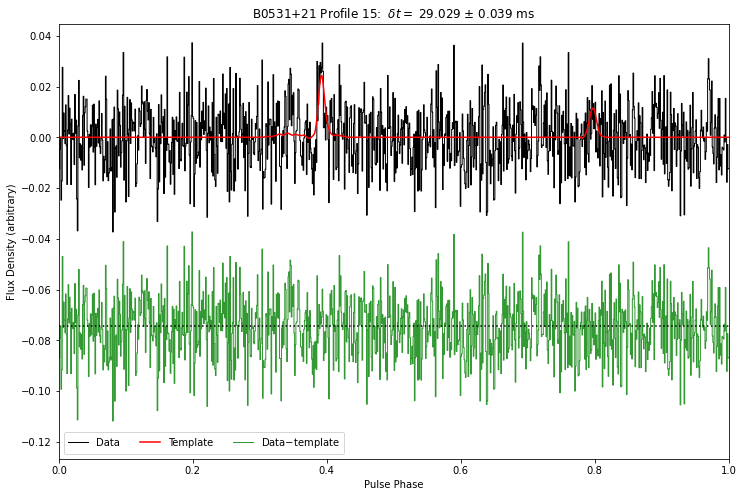

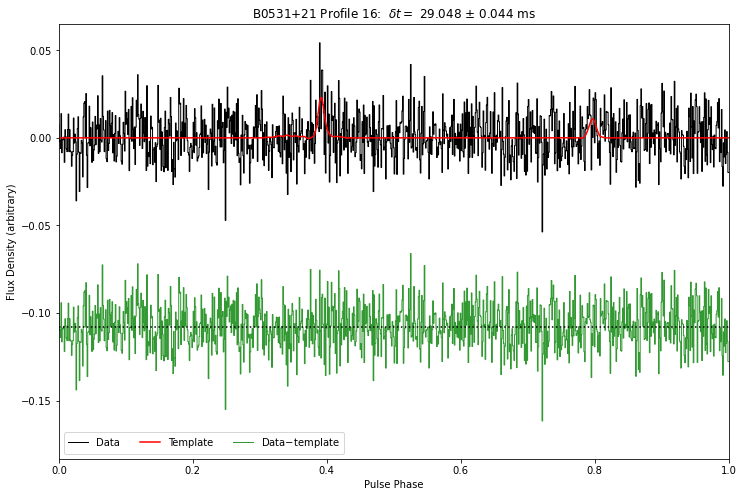

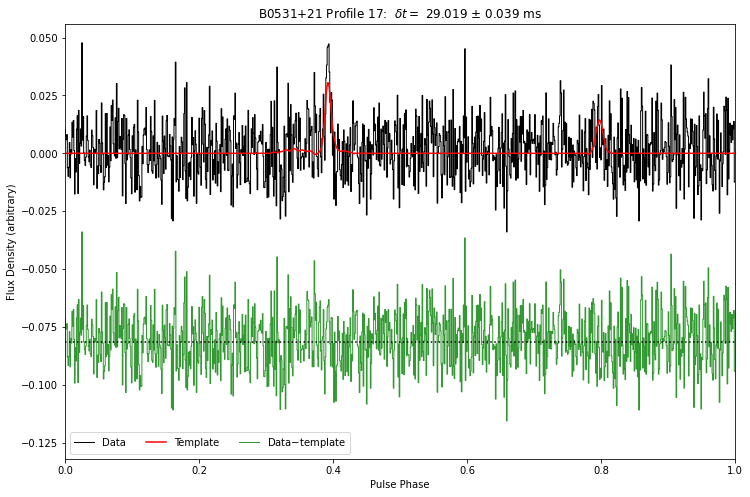

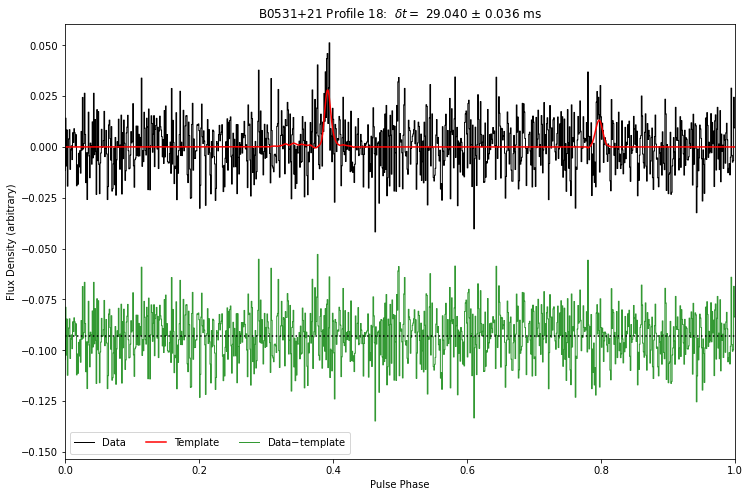

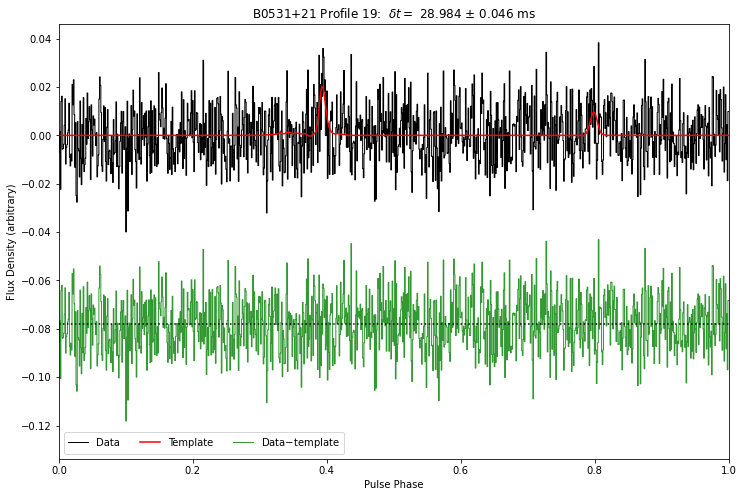

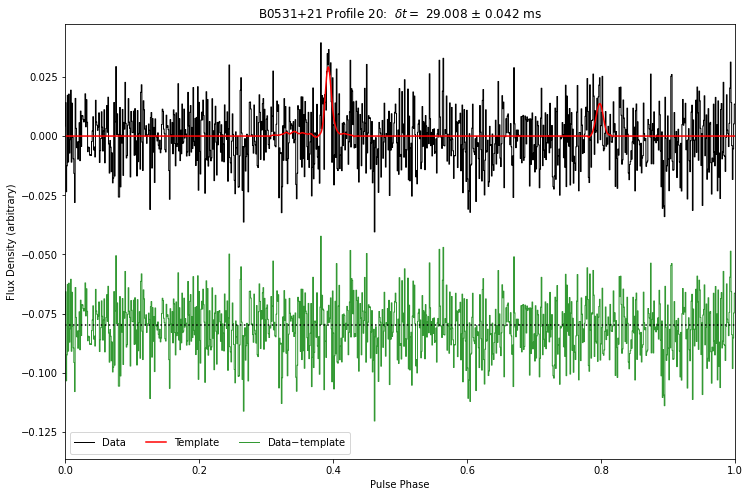

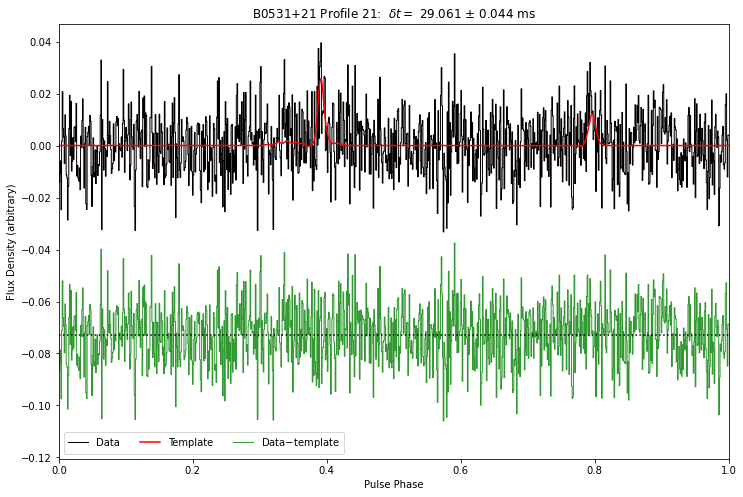

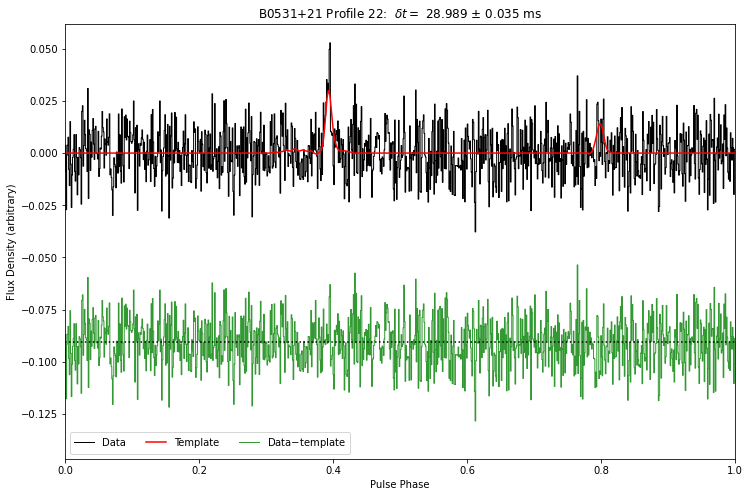

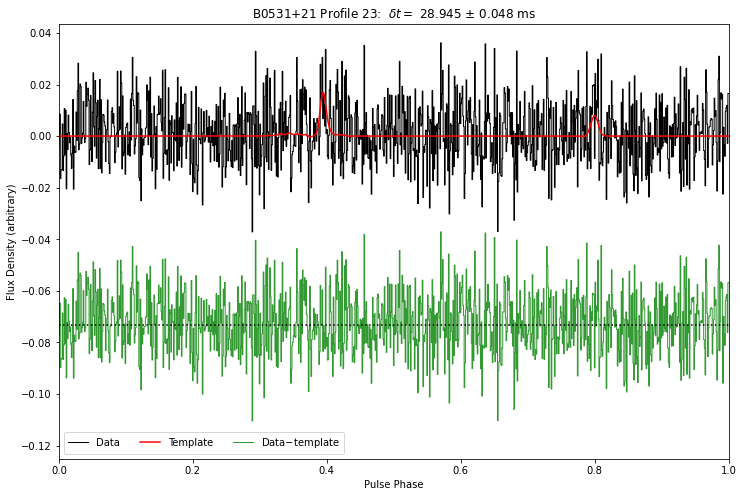

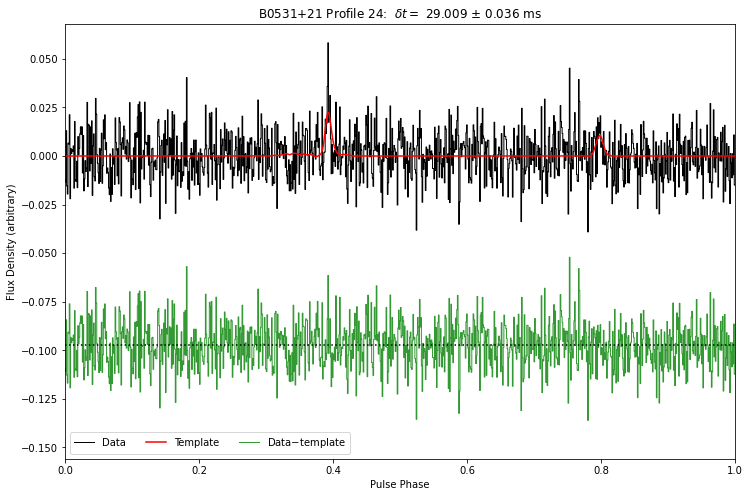

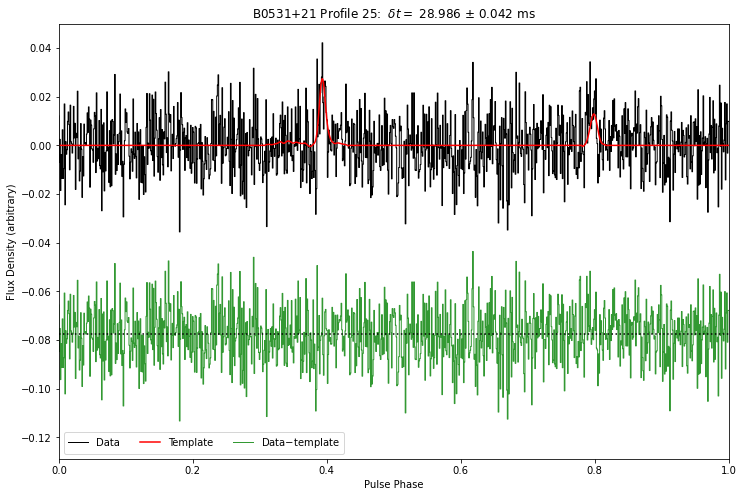

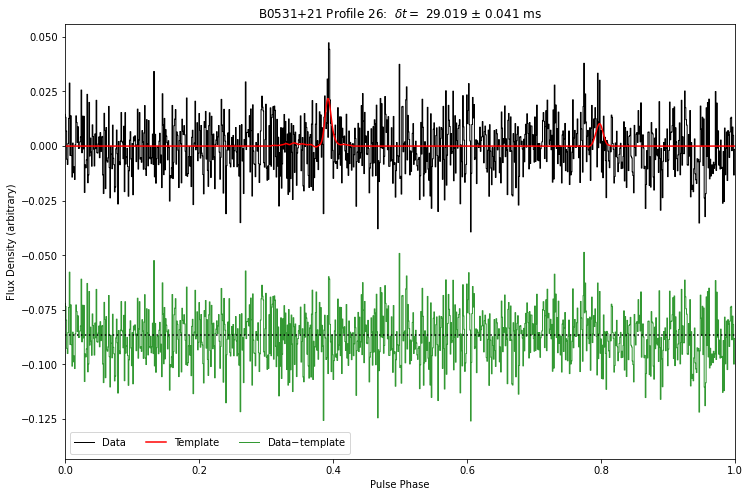

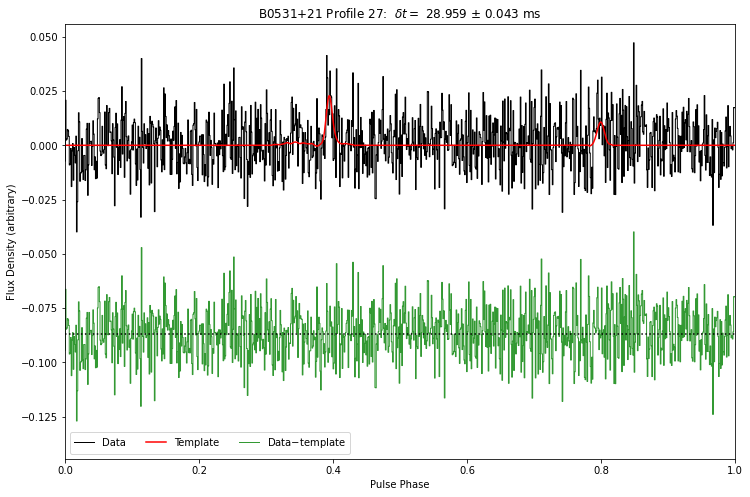

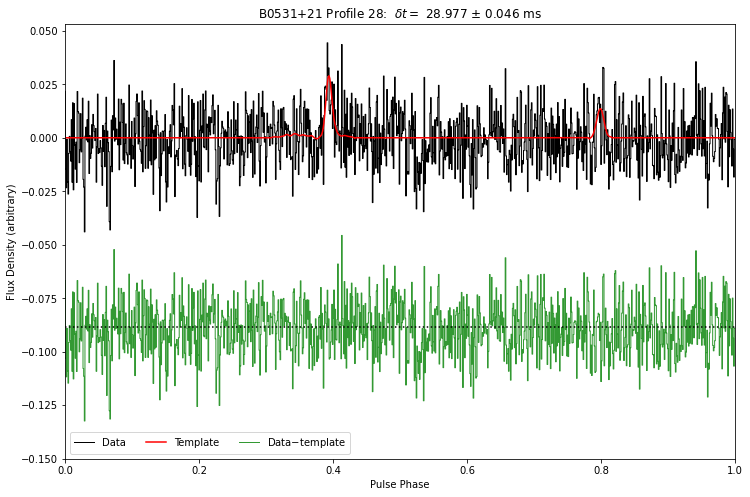

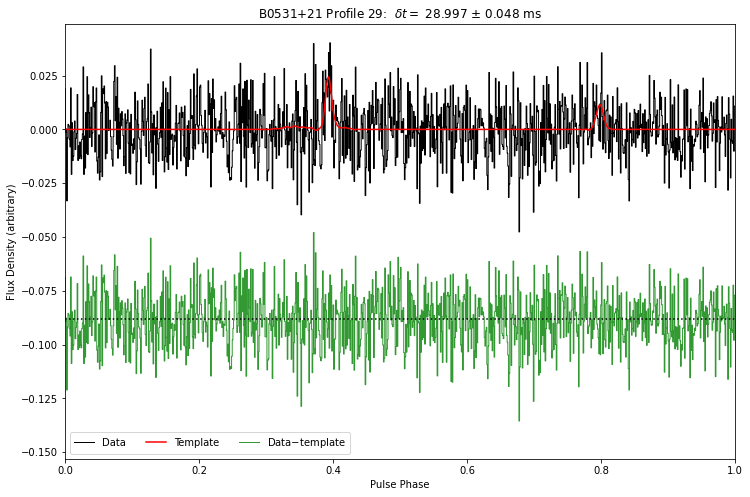

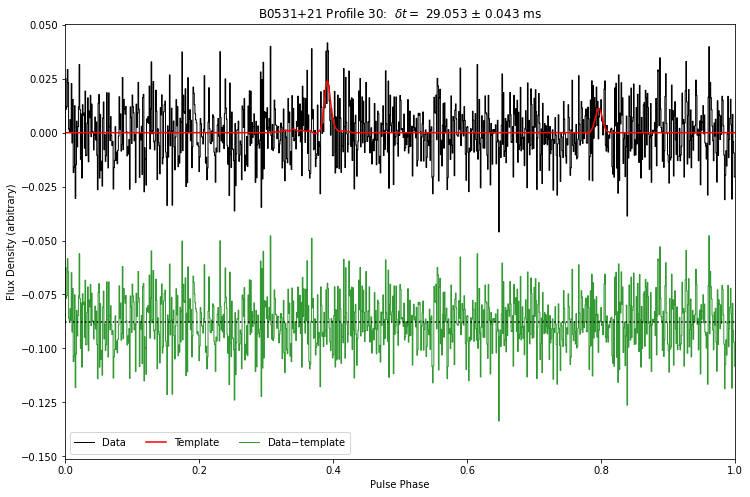

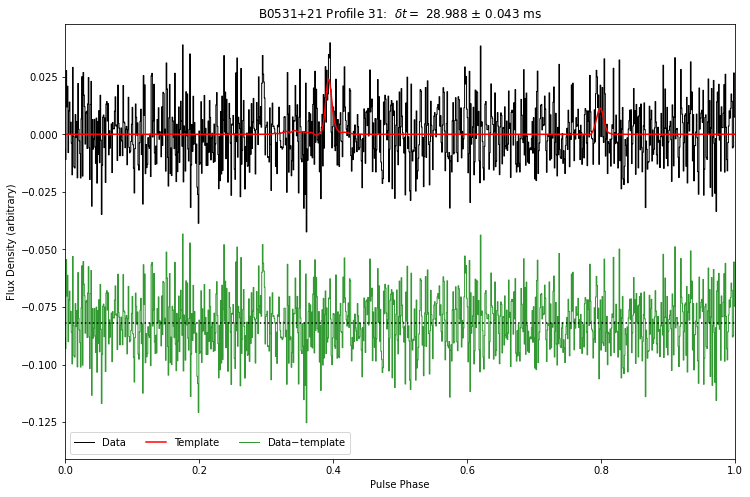

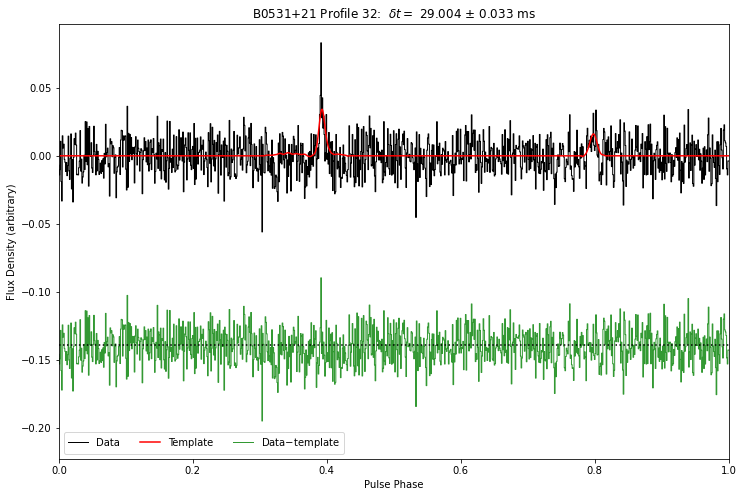

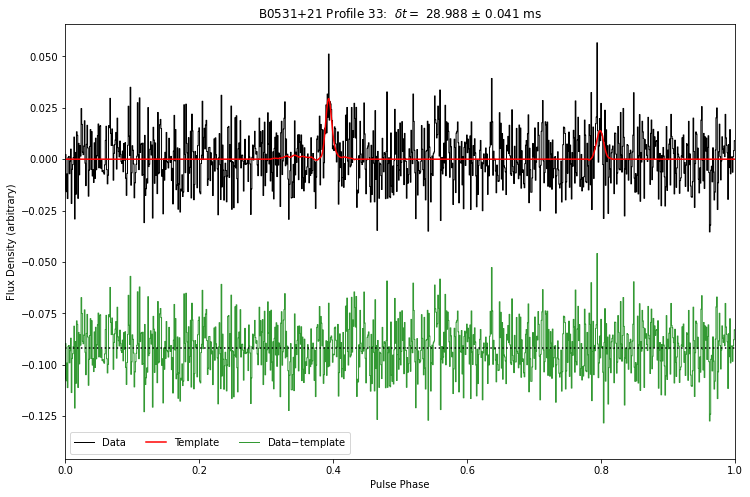

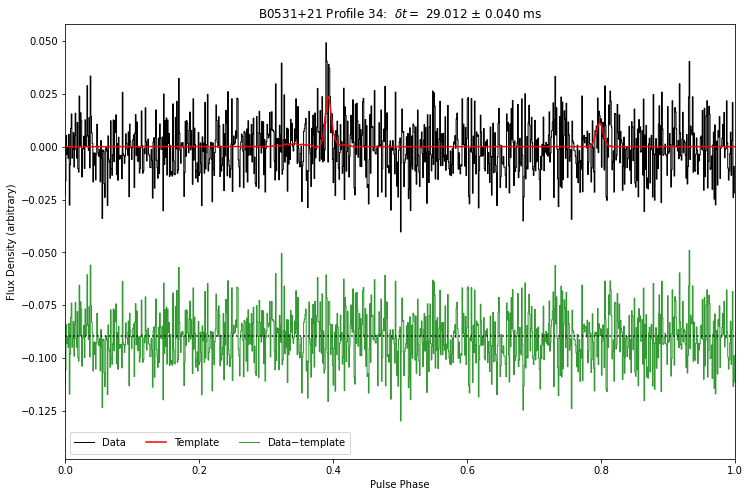

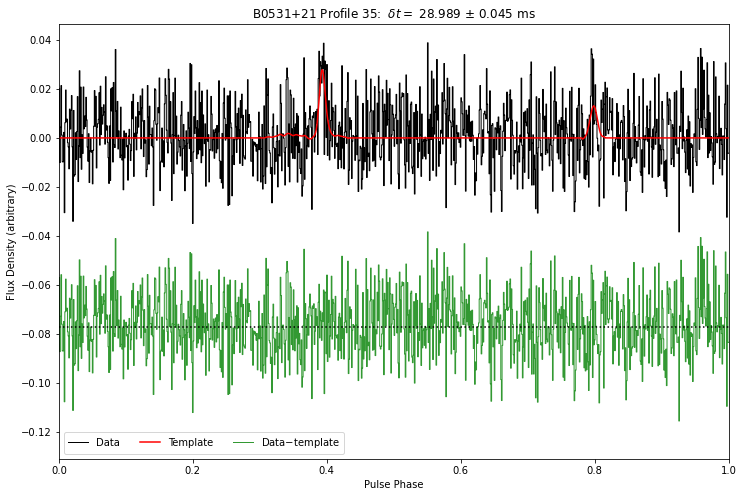

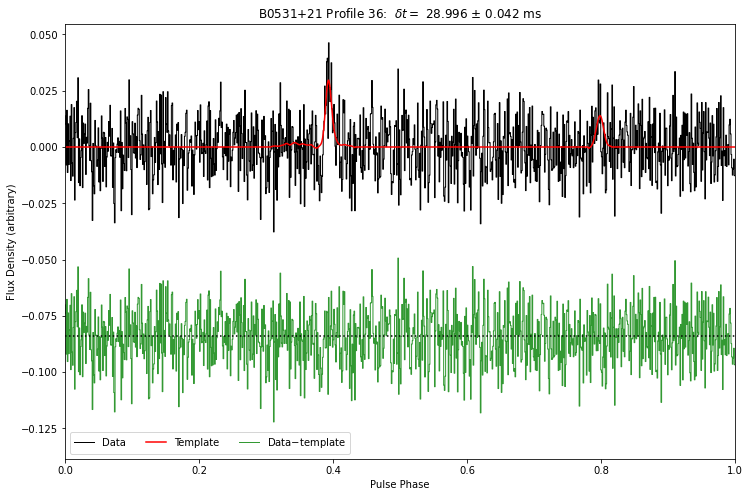

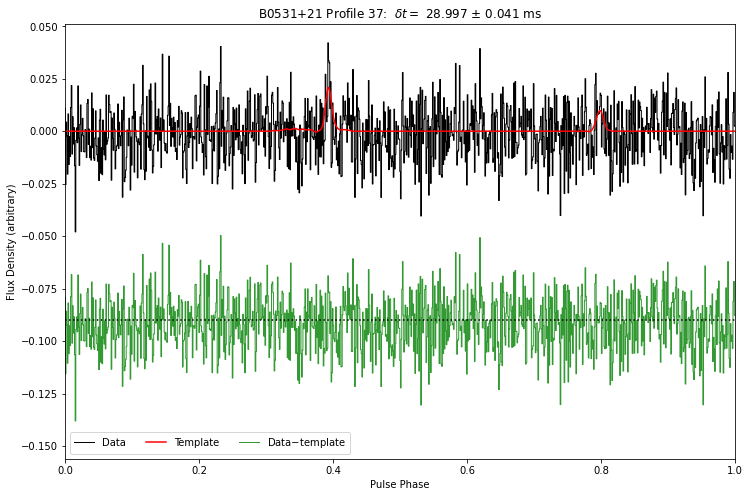

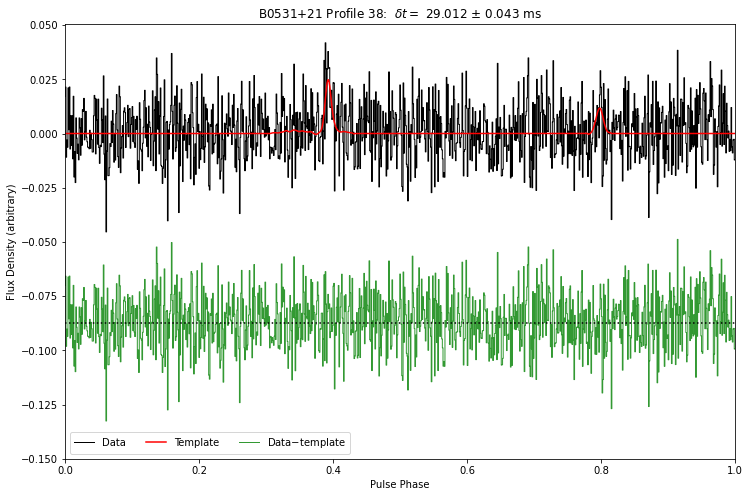

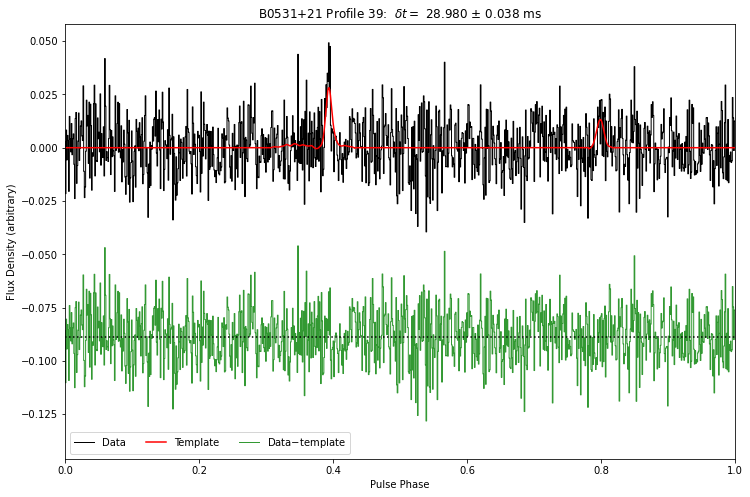

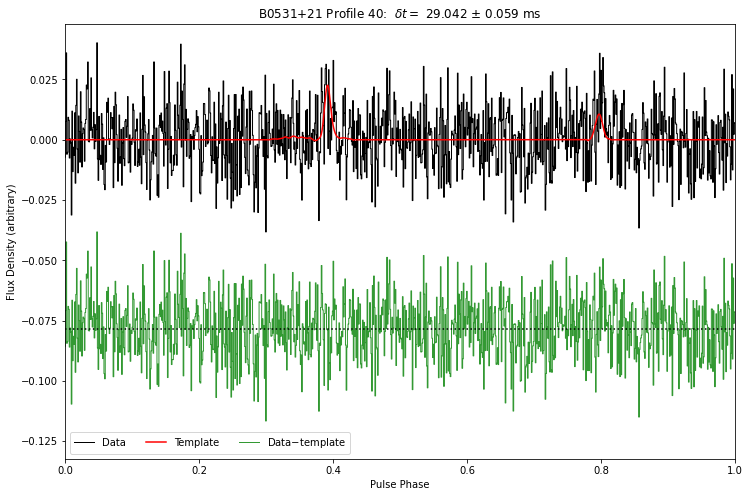

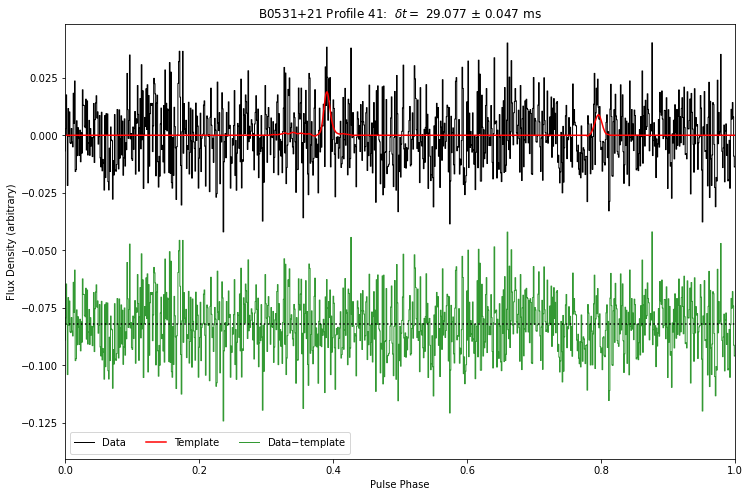

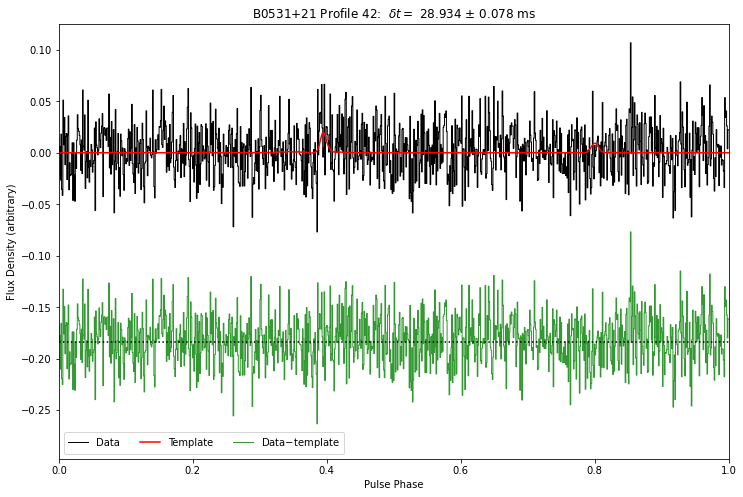

In [7]:


times=obsdata['times'] # The time of phase zero for each subint
approx_period=obsdata['approx_period'] # The approximate period of the pulsar
toas=[]
toa_errs=[]
tempo2_toas=[]

# Loop over every sub integration
for ip in range(len(ddfreq_averaged)):
    prof=ddfreq_averaged[ip]
    nbin=len(prof)
    
    # We are going to do a cross correlation by means of the Fourier transform and the Wiener-Kinchin theorem
    f_template = np.fft.rfft(template)
    f_prof = np.fft.rfft(prof)

    # The cross correlation of a and b is the inverse transform of FT(a) times the conjugate of FT(b)
    xspec= f_template * f_prof.conj() # "cross spectrum"
    xcor = np.fft.irfft(xspec) # Cross correlation

    ishift = np.argmax(np.abs(xcor)) # estimate of the shift directly from the peak cross-correlation

    # We need to define some bounds to search. (Actually this might not be optimal)
    lo=ishift-1
    hi=ishift+1
    nh=len(xspec)
    # We minimise the chisquare parameter by findng the root of it's derivatiive following Taylor 1992 
    # This root_scalar method uses the 'Brent 1973' algorithm for root finding.
    ret = opt.root_scalar(get_dchi,bracket=(lo,hi),x0=ishift,args=(nh,nbin),method='brentq')
    
    # tau is the bin shift between data and template, which will become our ToA
    tau=ret.root
    # Again folow the math of Taylor 1992 to get the scale factor, which it calls 'b'
    scale=get_b(tau,nh,nbin)
    # And finally given the shift and scale we can find the uncertainty on the shift.
    sigma_tau=get_sigma_tau(tau,nh,nbin,scale)
    
    # Phase shift is bin shift divided by nbins
    phase_shift = tau/nbin
    
    # ToA is the phase shift converted to a time shift and added to the time of phase zero.
    toa = times[ip]+approx_period*tau/nbin/86400.0
    toa_err = approx_period*sigma_tau/nbin
    tempo2_toa=" test 611 {:.16f} {} jb42\n".format(toa,toa_err)
    
    toas.append(toa)
    toa_errs.append(toa_err)
    tempo2_toas.append(tempo2_toa)
    
    phase=np.linspace(0,1,nbin)
    
    rotate_and_scaled_template=scale*rotate_phs(f_template,phase_shift)
    diff=prof-rotate_and_scaled_template
    
    d= np.amax(prof)-np.amin(prof)
        
    # And do some plotting...
    plt.figure(figsize=(12,8))
    plt.xlabel("Pulse Phase")
    plt.ylabel("Flux Density (arbitrary)")

    plt.title(r"{} Profile {:d}:  $\delta t =$ {:.3f} $\pm$ {:.3f} ms".format(obsdata['source_name'],ip,1e3*approx_period*phase_shift,1e3*toa_err))
    plt.step(phase,prof,color='black',linewidth=1.0,label="Data")
    plt.plot(phase,rotate_and_scaled_template,color='red',label="Template")

    plt.step(phase,diff-d,color='green',linewidth=1.0,alpha=0.8,label=r"Data$-$template")
    plt.axhline(-d,ls=":",color='k')

    plt.xlim(0,1)
    plt.ylim(np.amin(prof)-1.2*d,np.amax(prof)+0.1*d)

    plt.legend(loc="lower left",ncol=3)

    plt.show()
    plt.close()
    

In [8]:
for t,e in zip(toas,toa_errs):
    print("{:.18f} {:.3g}".format(t,e))

59723.712152749940287322 4.41e-05
59723.714351924601942301 5.23e-05
59723.716666515516408253 5.91e-05
59723.718981889374845196 5.47e-05
59723.721296480594901368 4.36e-05
59723.723611463829001877 4.2e-05
59723.725926446313678753 4.43e-05
59723.728240646349149756 6.99e-05
59723.730555629670561757 4.19e-05
59723.732870220825134311 3.79e-05
59723.735185203506262042 3.8e-05
59723.737499795744952280 4.01e-05
59723.739814778251457028 4.04e-05
59723.742129760546959005 4.2e-05
59723.744444352276332211 3.93e-05
59723.746759334957459942 3.88e-05
59723.749073926752316765 4.37e-05
59723.751388909251545556 3.9e-05
59723.753703501075506210 3.6e-05
59723.756018483283696696 4.57e-05
59723.758333466408657841 4.22e-05
59723.760648058640072122 4.42e-05
59723.762963040673639625 3.5e-05
59723.765277631799108349 4.77e-05
59723.767592615411558654 3.63e-05
59723.769907206791685894 4.22e-05
59723.772222190076718107 4.11e-05
59723.774537172277632635 4.33e-05
59723.776851764145249035 4.63e-05
59723.77916674728476